# Task
Perform an exploratory data analysis on the 'train' split of the `ds` dataset, which includes analyzing the distributions of 'field' and 'primary_subfield' columns, calculating and visualizing the lengths of 'title', 'abstract', and 'fulltext' columns, examining the temporal distribution of the 'created' column, checking for missing values across all columns, and displaying sample data for each field.

In [1]:
from datasets import load_dataset

ds = load_dataset("allenai/multixscience_sparse_mean")

c:\Users\Lenovo\Documents\S2\NLP\Tubes-NLP-PaperMatch\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Explore field and primary_subfield distributions

### Subtask:
Analyze the unique values and their frequencies in the 'field' and 'primary_subfield' columns to understand the main categories of papers in the dataset. This will provide insights into the subject areas covered.


**Reasoning**:
First, I will convert the 'train' split of the dataset into a Pandas DataFrame to easily access and analyze the columns. Then, I will print the value counts for the 'field' and 'primary_subfield' columns to show their distributions.



In [2]:
train_df = ds["train"].to_pandas()

train_df.head()

,aid,mid,abstract,related_work,ref_abstract
0,math9912167,1631980677,"Author(s): Kuperberg, Greg; Thurston, Dylan P....",Two other generalizations that can be consider...,"{'cite_N': ['@cite_16', '@cite_26'], 'mid': ['..."
1,cs9910011,2168463568,A statistical model for segmentation and word ...,"Model Based Dynamic Programming, hereafter ref...","{'cite_N': ['@cite_0'], 'mid': ['2074546930'],..."
2,cs9911003,2950670108,We solve the subgraph isomorphism problem in p...,Recently we were able to characterize the grap...,"{'cite_N': ['@cite_41'], 'mid': ['2074992286']..."
3,hep-th9908200,2160091034,Daviau showed the equivalence of matrix Dirac ...,A further genuine and important approach to th...,"{'cite_N': ['@cite_6'], 'mid': ['2082565556'],..."
4,cs9903014,1612660921,We present an open architecture for just-in-ti...,Pioneering research in dynamic runtime optimiz...,"{'cite_N': ['@cite_8'], 'mid': ['2101776604'],..."


In [3]:
mid = train_df['ref_abstract'][0]['mid']
train_df['ref_abstract'][0]

{'cite_N': array(['@cite_16', '@cite_26'], dtype=object),
 'mid': array(['1481005306', '1641082372'], dtype=object),
 'abstract': array(['This note is a sequel to our earlier paper of the same title [4] and describes invariants of rational homology 3-spheres associated to acyclic orthogonal local systems. Our work is in the spirit of the Axelrod–Singer papers [1], generalizes some of their results, and furnishes a new setting for the purely topological implications of their work.',
        'Recently, Mullins calculated the Casson-Walker invariant of the 2-fold cyclic branched cover of an oriented link in S^3 in terms of its Jones polynomial and its signature, under the assumption that the 2-fold branched cover is a rational homology 3-sphere. Using elementary principles, we provide a similar calculation for the general case. In addition, we calculate the LMO invariant of the p-fold branched cover of twisted knots in S^3 in terms of the Kontsevich integral of the knot.'],
       dtype=o

In [4]:
train_df['mid'] = train_df['mid'].astype(int)

In [5]:
train_df.dtypes

aid             object
mid              int64
abstract        object
related_work    object
ref_abstract    object
dtype: object

In [6]:
train_df.loc[train_df['mid']==1641082372]['abstract']

Series([], Name: abstract, dtype: object)

In [7]:
import ast
train_df['list_mid'] = train_df['ref_abstract'].apply(lambda x: x['mid'])
train_df['list_mid'].head()

flat = [int(item) for sublist in train_df['list_mid'] for item in sublist if len(item)>0]

In [8]:
founded_number = sum(1 for item in flat if train_df['mid'].isin([item]).any())
founded_number

2731

Sedang memproses kolom referensi (ini mungkin memakan waktu)...


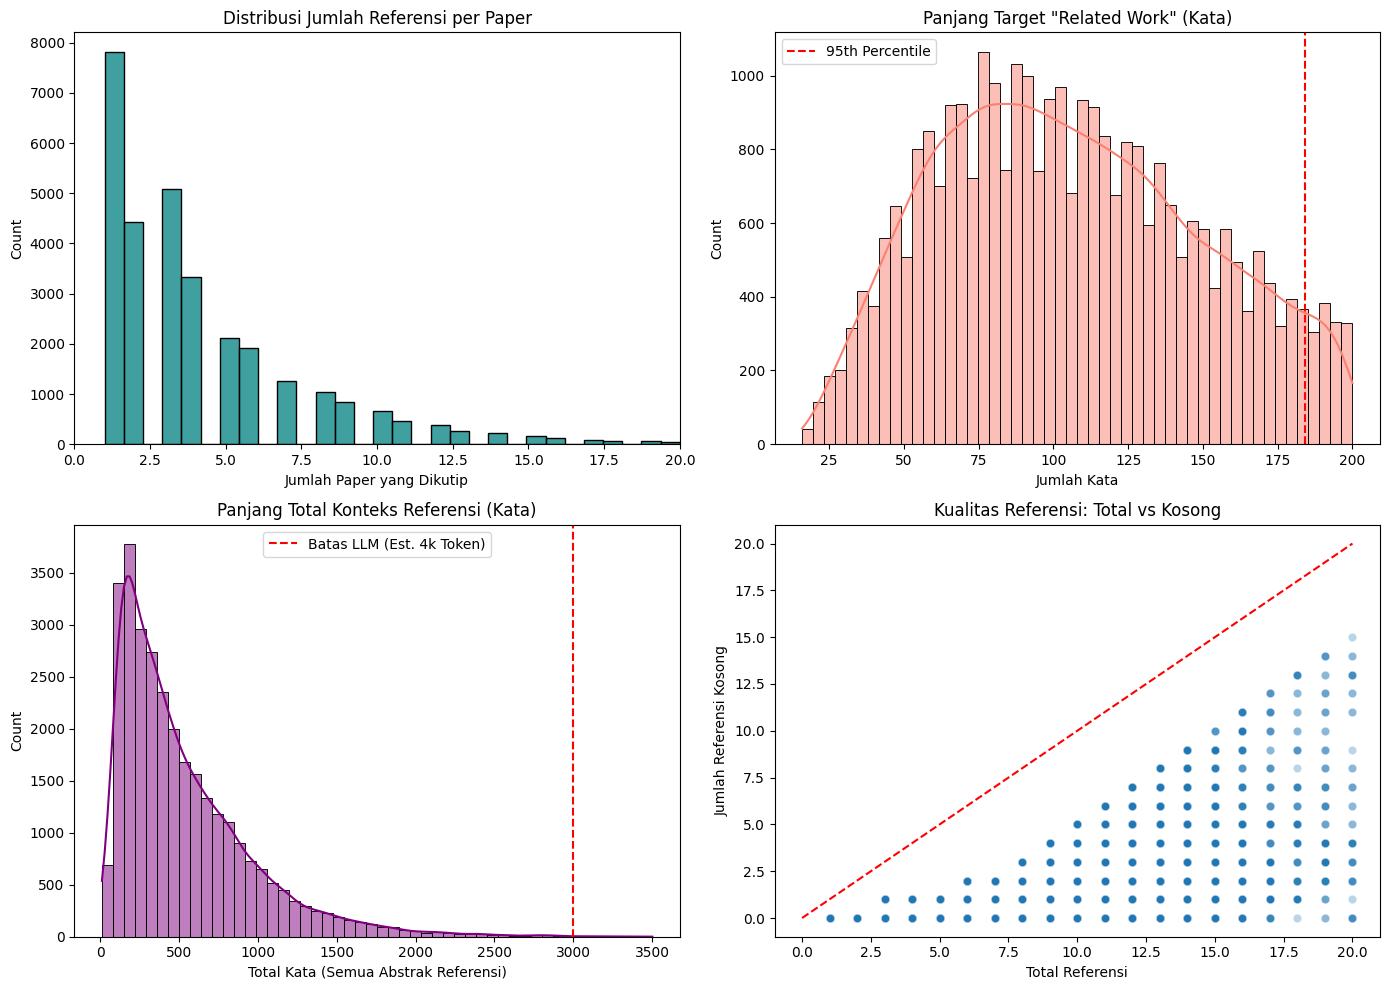


=== REKOMENDASI PARAMETER FINE-TUNING ===
Rata-rata Jumlah Referensi : 4.1 paper
Max Target Length (95%)    : 184 kata (~239 token)
Max Context Length (95%)   : 1387 kata (~1803 token)

⚠️ Data dengan referensi kosong (Potensi Halusinasi): 11032 baris (36.3%)
Saran: Filter (buang) baris ini sebelum training.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. PARSING KOLOM STRUKTUR (Ref Abstract) ---
# Kolom 'ref_abstract' biasanya berupa dictionary/struct. Kita perlu ekstrak isinya.
# Format di MultiXScience biasanya: {'abstract': ['text1', 'text2'], 'mid': [...]}

print("Sedang memproses kolom referensi (ini mungkin memakan waktu)...")

def get_ref_stats(row):
    refs = row['ref_abstract']
    
    # Cek apakah kosong
    if not refs or 'abstract' not in refs:
        return 0, 0, 0
    
    # Daftar abstrak referensi (list of strings)
    ref_abstracts = refs['abstract']
    
    # 1. Jumlah Referensi
    num_refs = len(ref_abstracts)
    
    # 2. Total Panjang Teks Referensi (Input Context)
    # Kita gabungkan semua abstrak referensi jadi satu string panjang
    context_text = " ".join([txt for txt in ref_abstracts if txt])
    context_len = len(context_text.split()) # Estimasi kata
    
    # 3. Cek Referensi Kosong (Missing Abstracts)
    # Berapa banyak referensi yang abstraknya cuma string kosong ""?
    empty_refs = sum(1 for txt in ref_abstracts if not txt or len(txt.strip()) < 10)
    
    return num_refs, context_len, empty_refs

# Terapkan ke dataframe (gunakan sampel jika data > 50k agar cepat)
# df_eda = train_df.sample(10000, random_state=42).copy() # Uncomment jika ingin sampling
df_eda = train_df.copy()

# Buat kolom statistik baru
stats = df_eda.apply(get_ref_stats, axis=1, result_type='expand')
df_eda[['num_refs', 'context_word_count', 'empty_refs_count']] = stats

# Hitung panjang target (Related Work)
df_eda['target_word_count'] = df_eda['related_work'].astype(str).apply(lambda x: len(x.split()))

# --- 2. VISUALISASI DISTRIBUSI ---

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot A: Berapa banyak referensi yang dikutip?
sns.histplot(df_eda['num_refs'], bins=30, kde=False, ax=axes[0,0], color='teal')
axes[0,0].set_title('Distribusi Jumlah Referensi per Paper')
axes[0,0].set_xlabel('Jumlah Paper yang Dikutip')
axes[0,0].set_xlim(0, 20) # Zoom in ke range wajar

# Plot B: Seberapa panjang bab Related Work aslinya? (Target Length)
sns.histplot(df_eda['target_word_count'], bins=50, kde=True, ax=axes[0,1], color='salmon')
axes[0,1].set_title('Panjang Target "Related Work" (Kata)')
axes[0,1].set_xlabel('Jumlah Kata')
axes[0,1].axvline(df_eda['target_word_count'].quantile(0.95), color='red', linestyle='--', label='95th Percentile')
axes[0,1].legend()

# Plot C: Seberapa panjang Total Context (Gabungan semua ref)? (Input Length)
sns.histplot(df_eda['context_word_count'], bins=50, kde=True, ax=axes[1,0], color='purple')
axes[1,0].set_title('Panjang Total Konteks Referensi (Kata)')
axes[1,0].set_xlabel('Total Kata (Semua Abstrak Referensi)')
# Garis batas token LLM (misal 4096 token approx 3000 kata)
axes[1,0].axvline(3000, color='red', linestyle='--', label='Batas LLM (Est. 4k Token)')
axes[1,0].legend()

# Plot D: Kualitas Data (Empty References)
# Apakah ada paper yang referensinya "bolong"?
sns.scatterplot(data=df_eda, x='num_refs', y='empty_refs_count', ax=axes[1,1], alpha=0.3)
axes[1,1].set_title('Kualitas Referensi: Total vs Kosong')
axes[1,1].set_xlabel('Total Referensi')
axes[1,1].set_ylabel('Jumlah Referensi Kosong')
axes[1,1].plot([0, 20], [0, 20], 'r--', label='Semua Kosong') # Garis diagonal

plt.tight_layout()
plt.show()

# --- 3. STATISTIK KUNCI UNTUK FINE-TUNING ---
print("\n=== REKOMENDASI PARAMETER FINE-TUNING ===")
print(f"Rata-rata Jumlah Referensi : {df_eda['num_refs'].mean():.1f} paper")
print(f"Max Target Length (95%)    : {df_eda['target_word_count'].quantile(0.95):.0f} kata (~{int(df_eda['target_word_count'].quantile(0.95)*1.3)} token)")
print(f"Max Context Length (95%)   : {df_eda['context_word_count'].quantile(0.95):.0f} kata (~{int(df_eda['context_word_count'].quantile(0.95)*1.3)} token)")

# Cek data yang harus dibuang
bad_data = len(df_eda[df_eda['empty_refs_count'] > 0])
print(f"\n⚠️ Data dengan referensi kosong (Potensi Halusinasi): {bad_data} baris ({bad_data/len(df_eda)*100:.1f}%)")
print("Saran: Filter (buang) baris ini sebelum training.")